# Implementing a Low Rank Adapter (LoRA) (8 points)

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References:

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 124996876.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15323933.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36182334.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21309316.30it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [ ]:
#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()

        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()


        self.dropout = nn.Dropout(0.5)



    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [ ]:
#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

#to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
#so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()

    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation')
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())

    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)

        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)

    return train_loss_lst, val_loss_lst

In [ ]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst,label="train")
    plt.plot(val_loss_lst,label="val")
    plt.legend()

# If you have GPU access, or simply want to train your own model, run this code

In [ ]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

Training: 100%|██████████| 168/168 [00:09<00:00, 17.49it/s, loss=0.15]


Epoch [1/30] Train Loss: 0.14974932339308517


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.83it/s, loss=0.0825]


Epoch [1/30] Validation Loss: 0.08251338893185473


Training: 100%|██████████| 168/168 [00:05<00:00, 28.27it/s, loss=0.0727]


Epoch [2/30] Train Loss: 0.0727058290171304


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.37it/s, loss=0.0739]


Epoch [2/30] Validation Loss: 0.07392260182597157


Training: 100%|██████████| 168/168 [00:05<00:00, 31.79it/s, loss=0.0526]


Epoch [3/30] Train Loss: 0.05263905182004064


Validation: 100%|██████████| 72/72 [00:02<00:00, 28.32it/s, loss=0.045]


Epoch [3/30] Validation Loss: 0.044970981440403394


Training: 100%|██████████| 168/168 [00:05<00:00, 28.62it/s, loss=0.051]


Epoch [4/30] Train Loss: 0.051019202169430046


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.21it/s, loss=0.0399]


Epoch [4/30] Validation Loss: 0.039921130816057686


Training: 100%|██████████| 168/168 [00:05<00:00, 28.09it/s, loss=0.0439]


Epoch [5/30] Train Loss: 0.04388246592550006


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.47it/s, loss=0.057]


Epoch [5/30] Validation Loss: 0.05699470036132778


Training: 100%|██████████| 168/168 [00:06<00:00, 27.91it/s, loss=0.0388]


Epoch [6/30] Train Loss: 0.0388344281292077


Validation: 100%|██████████| 72/72 [00:02<00:00, 24.99it/s, loss=0.0555]


Epoch [6/30] Validation Loss: 0.0555133964581829


Training: 100%|██████████| 168/168 [00:05<00:00, 30.36it/s, loss=0.0382]


Epoch [7/30] Train Loss: 0.03818635740650019


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.35it/s, loss=0.0471]


Epoch [7/30] Validation Loss: 0.04714426022757026


Training: 100%|██████████| 168/168 [00:05<00:00, 28.98it/s, loss=0.0322]


Epoch [8/30] Train Loss: 0.032195798712477665


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.94it/s, loss=0.0435]


Epoch [8/30] Validation Loss: 0.04350943462062181


Training: 100%|██████████| 168/168 [00:05<00:00, 32.03it/s, loss=0.0325]


Epoch [9/30] Train Loss: 0.032548023160156196


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.80it/s, loss=0.0363]


Epoch [9/30] Validation Loss: 0.03634637334946294


Training: 100%|██████████| 168/168 [00:05<00:00, 29.14it/s, loss=0.0323]


Epoch [10/30] Train Loss: 0.032335361063208744


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.83it/s, loss=0.0439]


Epoch [10/30] Validation Loss: 0.04394077951696494


Training: 100%|██████████| 168/168 [00:06<00:00, 24.30it/s, loss=0.0353]


Epoch [11/30] Train Loss: 0.03525609094746566


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.74it/s, loss=0.0402]


Epoch [11/30] Validation Loss: 0.04019067670136186


Training: 100%|██████████| 168/168 [00:05<00:00, 31.82it/s, loss=0.0289]


Epoch [12/30] Train Loss: 0.02887745749432638


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.38it/s, loss=0.048]


Epoch [12/30] Validation Loss: 0.047962664700106766


Training: 100%|██████████| 168/168 [00:06<00:00, 25.73it/s, loss=0.0332]


Epoch [13/30] Train Loss: 0.033212027780661756


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.92it/s, loss=0.0495]


Epoch [13/30] Validation Loss: 0.04945662647716947


Training: 100%|██████████| 168/168 [00:06<00:00, 27.36it/s, loss=0.0241]


Epoch [14/30] Train Loss: 0.024146842429088013


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.03it/s, loss=0.0454]


Epoch [14/30] Validation Loss: 0.045374524898256316


Training: 100%|██████████| 168/168 [00:05<00:00, 31.61it/s, loss=0.0311]


Epoch [15/30] Train Loss: 0.031124311276514726


Validation: 100%|██████████| 72/72 [00:02<00:00, 30.71it/s, loss=0.0622]


Epoch [15/30] Validation Loss: 0.062247429725781935


Training: 100%|██████████| 168/168 [00:05<00:00, 28.63it/s, loss=0.0277]


Epoch [16/30] Train Loss: 0.027696087993977665


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.88it/s, loss=0.0529]


Epoch [16/30] Validation Loss: 0.0529151780938264


Training: 100%|██████████| 168/168 [00:06<00:00, 28.00it/s, loss=0.0261]


Epoch [17/30] Train Loss: 0.026115033389335924


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.39it/s, loss=0.042]


Epoch [17/30] Validation Loss: 0.04201710590723451


Training: 100%|██████████| 168/168 [00:05<00:00, 31.01it/s, loss=0.0265]


Epoch [18/30] Train Loss: 0.026536672590910235


Validation: 100%|██████████| 72/72 [00:02<00:00, 30.92it/s, loss=0.0423]


Epoch [18/30] Validation Loss: 0.042308687057862296


Training: 100%|██████████| 168/168 [00:06<00:00, 27.91it/s, loss=0.0236]


Epoch [19/30] Train Loss: 0.023623232239472037


Validation: 100%|██████████| 72/72 [00:02<00:00, 29.91it/s, loss=0.0461]


Epoch [19/30] Validation Loss: 0.046063210224600776


Training: 100%|██████████| 168/168 [00:06<00:00, 27.31it/s, loss=0.0189]


Epoch [20/30] Train Loss: 0.018922397777628032


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.42it/s, loss=0.0467]


Epoch [20/30] Validation Loss: 0.046737306796962405


Training: 100%|██████████| 168/168 [00:05<00:00, 31.95it/s, loss=0.022]


Epoch [21/30] Train Loss: 0.02201877897451119


Validation: 100%|██████████| 72/72 [00:02<00:00, 30.56it/s, loss=0.0506]


Epoch [21/30] Validation Loss: 0.050577840019589836


Training: 100%|██████████| 168/168 [00:05<00:00, 28.11it/s, loss=0.0274]


Epoch [22/30] Train Loss: 0.027364984396453587


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.83it/s, loss=0.045]


Epoch [22/30] Validation Loss: 0.04503257767871421


Training: 100%|██████████| 168/168 [00:06<00:00, 27.32it/s, loss=0.027]


Epoch [23/30] Train Loss: 0.026974615275575854


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.72it/s, loss=0.046]


Epoch [23/30] Validation Loss: 0.04601384805662039


Training: 100%|██████████| 168/168 [00:05<00:00, 30.21it/s, loss=0.0247]


Epoch [24/30] Train Loss: 0.024679075321121974


Validation: 100%|██████████| 72/72 [00:02<00:00, 28.49it/s, loss=0.052]


Epoch [24/30] Validation Loss: 0.051963286942938995


Training: 100%|██████████| 168/168 [00:05<00:00, 28.77it/s, loss=0.0227]


Epoch [25/30] Train Loss: 0.02269305546247952


Validation: 100%|██████████| 72/72 [00:02<00:00, 26.43it/s, loss=0.0425]


Epoch [25/30] Validation Loss: 0.04245810768144212


Training: 100%|██████████| 168/168 [00:06<00:00, 26.58it/s, loss=0.0244]


Epoch [26/30] Train Loss: 0.024409375068769026


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.16it/s, loss=0.0426]


Epoch [26/30] Validation Loss: 0.0425777312912285


Training: 100%|██████████| 168/168 [00:05<00:00, 30.55it/s, loss=0.026]


Epoch [27/30] Train Loss: 0.02596881687198523


Validation: 100%|██████████| 72/72 [00:02<00:00, 27.29it/s, loss=0.0372]


Epoch [27/30] Validation Loss: 0.03724991662567037


Training: 100%|██████████| 168/168 [00:07<00:00, 21.93it/s, loss=0.0276]


Epoch [28/30] Train Loss: 0.027648606950043314


Validation: 100%|██████████| 72/72 [00:04<00:00, 16.91it/s, loss=0.0443]


Epoch [28/30] Validation Loss: 0.04432549775060579


Training: 100%|██████████| 168/168 [00:06<00:00, 24.64it/s, loss=0.0292]


Epoch [29/30] Train Loss: 0.029202995721615957


Validation: 100%|██████████| 72/72 [00:03<00:00, 23.81it/s, loss=0.0453]


Epoch [29/30] Validation Loss: 0.04532906108960964


Training: 100%|██████████| 168/168 [00:06<00:00, 27.78it/s, loss=0.017]


Epoch [30/30] Train Loss: 0.016994555830738785


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.17it/s, loss=0.0497]

Epoch [30/30] Validation Loss: 0.049672105197689435


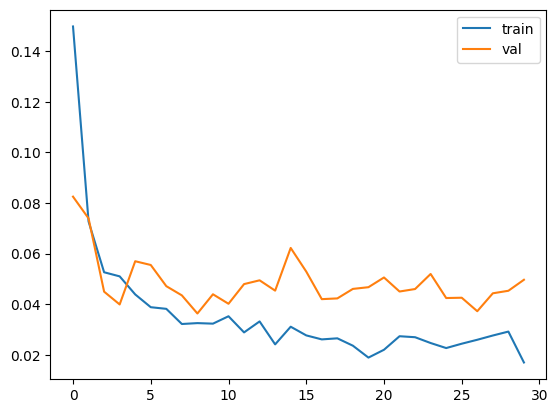

In [ ]:
plot_losses(train_loss_lst,val_loss_lst)

In [ ]:
# save the model
path1="/content/bieldavid_model_subset1.pth"
torch.save(net,path1)

path2="/content/bieldavid_model_subset1_state_dict.pth"
# Save the state dictionary
torch.save(net.state_dict(), path2)


# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/


In [ ]:
path1="/content/bieldavid_model_subset1.pth"
net=torch.load(path1).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [ ]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [ ]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')


Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [ ]:
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0

    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1

                total += 1

    accuracy = round(correct / total, 3)
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')

    return accuracy

In [ ]:

test(test_loader, "Testing", net, {i: 0 for i in range(5)})


Testing: 100%|██████████| 41/41 [00:01<00:00, 26.52it/s]

Accuracy: 0.992
Wrong counts for the digit 0: 4
Wrong counts for the digit 1: 9
Wrong counts for the digit 2: 18
Wrong counts for the digit 3: 6
Wrong counts for the digit 4: 5


0.992

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [ ]:
#same code as before except for the mask

# create a mask to filter indices for each label, retrieve digits 5...9

class_names = [5, 6, 7, 8, 9]
train_mask_subset2 = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)


# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [ ]:
test(test_loader_subset2, "Testing subset2", net, {i: 0 for i in range(10)})

# Obviously the wrong counts of digits 0 to 4 are zero because these digirs do not exist in test_loader_subset2.
# We observe an accuracy of 0.413, which is higher than random guess as expected

Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 29.55it/s]

Accuracy: 0.413
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 772
Wrong counts for the digit 6: 952
Wrong counts for the digit 7: 600
Wrong counts for the digit 8: 454
Wrong counts for the digit 9: 77


0.413

# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

In [ ]:
train_loss_subset2, val_loss_subset2 = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=30) # 30 epochs to allow fair comparison with LoRA below

Training: 100%|██████████| 161/161 [00:05<00:00, 29.58it/s, loss=6.43]


Epoch [1/30] Train Loss: 6.431466542415738


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.85it/s, loss=4.83]


Epoch [1/30] Validation Loss: 4.825417204179626


Training: 100%|██████████| 161/161 [00:08<00:00, 19.97it/s, loss=4.18]


Epoch [2/30] Train Loss: 4.184570537590832


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.05it/s, loss=2.79]


Epoch [2/30] Validation Loss: 2.792764071105183


Training: 100%|██████████| 161/161 [00:06<00:00, 25.75it/s, loss=2.46]


Epoch [3/30] Train Loss: 2.4602738396721597


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.97it/s, loss=1.59]


Epoch [3/30] Validation Loss: 1.5912655401920928


Training: 100%|██████████| 161/161 [00:07<00:00, 20.85it/s, loss=1.56]


Epoch [4/30] Train Loss: 1.5627476543373202


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.04it/s, loss=0.927]


Epoch [4/30] Validation Loss: 0.9266611916431482


Training: 100%|██████████| 161/161 [00:05<00:00, 27.44it/s, loss=1.02]


Epoch [5/30] Train Loss: 1.0249663184148183


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.05it/s, loss=0.604]


Epoch [5/30] Validation Loss: 0.6044821626898171


Training: 100%|██████████| 161/161 [00:05<00:00, 27.15it/s, loss=0.756]


Epoch [6/30] Train Loss: 0.7561442998255262


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.76it/s, loss=0.454]


Epoch [6/30] Validation Loss: 0.4542901183384052


Training: 100%|██████████| 161/161 [00:07<00:00, 22.39it/s, loss=0.603]


Epoch [7/30] Train Loss: 0.6026537233257886


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.16it/s, loss=0.371]


Epoch [7/30] Validation Loss: 0.37062859729580255


Training: 100%|██████████| 161/161 [00:05<00:00, 31.53it/s, loss=0.503]


Epoch [8/30] Train Loss: 0.5029750792136104


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.23it/s, loss=0.315]


Epoch [8/30] Validation Loss: 0.315378260569296


Training: 100%|██████████| 161/161 [00:05<00:00, 31.21it/s, loss=0.432]


Epoch [9/30] Train Loss: 0.43151430591293005


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.95it/s, loss=0.276]


Epoch [9/30] Validation Loss: 0.2757651296214781


Training: 100%|██████████| 161/161 [00:05<00:00, 27.50it/s, loss=0.39]


Epoch [10/30] Train Loss: 0.3902722374067543


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.72it/s, loss=0.245]


Epoch [10/30] Validation Loss: 0.24500575650861298


Training: 100%|██████████| 161/161 [00:05<00:00, 31.90it/s, loss=0.347]


Epoch [11/30] Train Loss: 0.3473641015357853


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.23it/s, loss=0.222]


Epoch [11/30] Validation Loss: 0.22216199338436127


Training: 100%|██████████| 161/161 [00:05<00:00, 28.44it/s, loss=0.319]


Epoch [12/30] Train Loss: 0.31942751392814683


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.61it/s, loss=0.203]


Epoch [12/30] Validation Loss: 0.20281446627948596


Training: 100%|██████████| 161/161 [00:05<00:00, 28.72it/s, loss=0.292]


Epoch [13/30] Train Loss: 0.2917295309327404


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.62it/s, loss=0.187]


Epoch [13/30] Validation Loss: 0.18746492784956229


Training: 100%|██████████| 161/161 [00:05<00:00, 30.23it/s, loss=0.273]


Epoch [14/30] Train Loss: 0.2726252949478463


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.93it/s, loss=0.175]


Epoch [14/30] Validation Loss: 0.1747133787991344


Training: 100%|██████████| 161/161 [00:05<00:00, 27.23it/s, loss=0.254]


Epoch [15/30] Train Loss: 0.2542461030046392


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.24it/s, loss=0.163]


Epoch [15/30] Validation Loss: 0.16322625039712244


Training: 100%|██████████| 161/161 [00:05<00:00, 29.76it/s, loss=0.24]


Epoch [16/30] Train Loss: 0.23984844640175007


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.78it/s, loss=0.154]


Epoch [16/30] Validation Loss: 0.15380218662861464


Training: 100%|██████████| 161/161 [00:05<00:00, 30.85it/s, loss=0.221]


Epoch [17/30] Train Loss: 0.2211199768396638


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.51it/s, loss=0.146]


Epoch [17/30] Validation Loss: 0.14595541304004364


Training: 100%|██████████| 161/161 [00:06<00:00, 26.29it/s, loss=0.214]


Epoch [18/30] Train Loss: 0.21438234137452167


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.00it/s, loss=0.14]


Epoch [18/30] Validation Loss: 0.1395786680497121


Training: 100%|██████████| 161/161 [00:05<00:00, 31.95it/s, loss=0.205]


Epoch [19/30] Train Loss: 0.20544351651246504


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.48it/s, loss=0.134]


Epoch [19/30] Validation Loss: 0.13376583850038223


Training: 100%|██████████| 161/161 [00:05<00:00, 31.24it/s, loss=0.189]


Epoch [20/30] Train Loss: 0.18900881175483977


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.47it/s, loss=0.128]


Epoch [20/30] Validation Loss: 0.1284295592079128


Training: 100%|██████████| 161/161 [00:05<00:00, 27.98it/s, loss=0.183]


Epoch [21/30] Train Loss: 0.18276519633783317


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.45it/s, loss=0.124]


Epoch [21/30] Validation Loss: 0.12353664690601653


Training: 100%|██████████| 161/161 [00:05<00:00, 31.11it/s, loss=0.177]


Epoch [22/30] Train Loss: 0.17695234280935726


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.84it/s, loss=0.119]


Epoch [22/30] Validation Loss: 0.11894668757483579


Training: 100%|██████████| 161/161 [00:05<00:00, 28.18it/s, loss=0.169]


Epoch [23/30] Train Loss: 0.16872410788576794


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.78it/s, loss=0.115]


Epoch [23/30] Validation Loss: 0.11515400078201639


Training: 100%|██████████| 161/161 [00:05<00:00, 27.94it/s, loss=0.161]


Epoch [24/30] Train Loss: 0.16114209518299338


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.29it/s, loss=0.112]


Epoch [24/30] Validation Loss: 0.11194760913866153


Training: 100%|██████████| 161/161 [00:05<00:00, 31.37it/s, loss=0.157]


Epoch [25/30] Train Loss: 0.15748398461789817


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.65it/s, loss=0.108]


Epoch [25/30] Validation Loss: 0.10789330368456633


Training: 100%|██████████| 161/161 [00:05<00:00, 27.38it/s, loss=0.149]


Epoch [26/30] Train Loss: 0.14924380884314917


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.17it/s, loss=0.105]


Epoch [26/30] Validation Loss: 0.10494459182887837


Training: 100%|██████████| 161/161 [00:05<00:00, 28.91it/s, loss=0.15]


Epoch [27/30] Train Loss: 0.1501147756989328


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.66it/s, loss=0.102]


Epoch [27/30] Validation Loss: 0.10230520130067632


Training: 100%|██████████| 161/161 [00:05<00:00, 30.71it/s, loss=0.139]


Epoch [28/30] Train Loss: 0.13872486133105266


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.36it/s, loss=0.1]


Epoch [28/30] Validation Loss: 0.1002654111471729


Training: 100%|██████████| 161/161 [00:06<00:00, 26.49it/s, loss=0.137]


Epoch [29/30] Train Loss: 0.13708453479668367


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.47it/s, loss=0.0973]


Epoch [29/30] Validation Loss: 0.09729946744830711


Training: 100%|██████████| 161/161 [00:05<00:00, 30.61it/s, loss=0.137]


Epoch [30/30] Train Loss: 0.1371257230870842


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.54it/s, loss=0.095]

Epoch [30/30] Validation Loss: 0.09500692763190338


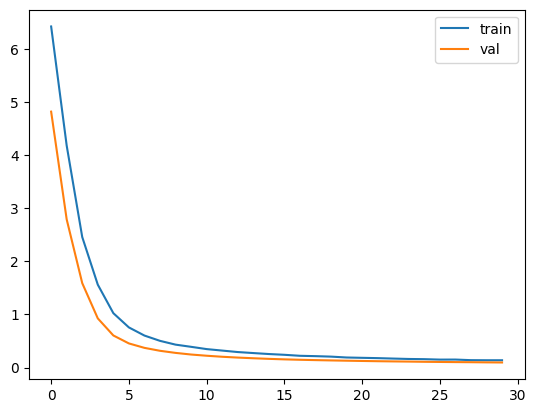

In [ ]:
#plot the train and validation losses
plot_losses(train_loss_subset2, val_loss_subset2)

In [ ]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot

path3="/content/bieldavid_model_subset2.pth"
torch.save(net,path3)

In [ ]:
# Cell to load the saved model

path2="/content/bieldavid_model_subset1_state_dict.pth"
path3="/content/bieldavid_model_subset2.pth"
net=torch.load(path3).to(device)

In [ ]:
accuracy_subset2 = test(test_loader_subset2, "Testing subset2", net, {i: 0 for i in range(10)})

# We get an accuracy of 0.97, which is pretty high

Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 30.38it/s]


Accuracy: 0.97
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 30
Wrong counts for the digit 6: 14
Wrong counts for the digit 7: 28
Wrong counts for the digit 8: 32
Wrong counts for the digit 9: 42


# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()

        # We first load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2))

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # We initialize parameters for LoRA with Xavier normal
        self.l1_lora_B = nn.Parameter(torch.randn(self.pretrained_net.linear1.in_features, lora_rank))
        self.l1_lora_A = nn.Parameter(torch.randn(lora_rank, self.pretrained_net.linear1.out_features))
        init.xavier_normal_(self.l1_lora_B)
        init.xavier_normal_(self.l1_lora_A)

        self.l2_lora_B = nn.Parameter(torch.randn(self.pretrained_net.linear2.in_features, lora_rank))
        self.l2_lora_A = nn.Parameter(torch.randn(lora_rank, self.pretrained_net.linear2.out_features))
        init.xavier_normal_(self.l2_lora_B)
        init.xavier_normal_(self.l2_lora_A)

        self.l3_lora_B = nn.Parameter(torch.randn(self.pretrained_net.linear3.in_features, lora_rank))
        self.l3_lora_A = nn.Parameter(torch.randn(lora_rank, self.pretrained_net.linear3.out_features))
        init.xavier_normal_(self.l3_lora_B)
        init.xavier_normal_(self.l3_lora_A)

        # Freeze non-LoRA weights
        for param in self.pretrained_net.parameters():
            param.requires_grad = False

    def lora_linear(self, x, original_layer, lora_B, lora_A):
        # Implement LoRA adaptation using formula (3) from the LoRA paper
        original_output = F.linear(x, original_layer.weight, original_layer.bias)
        return original_output + x @ lora_B @ lora_A

    def forward(self, input):
        x = input.view(-1, 28*28)

        # We apply LoRA for each layer
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_B, self.l1_lora_A)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_B, self.l2_lora_A)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_B, self.l3_lora_A)

        return x

lora_rank = 1
modified_net = ModifiedClassifier(lora_rank).to(device)

Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

In [ ]:
# We count the parameters introduced by lora layers
def count_lora_parameters(model):
    model.eval()
    lora_param_count = 0
    for name, param in model.named_parameters():
        if 'lora' in name:
            lora_param_count += torch.numel(param)
    return lora_param_count

print("Number of parameters introduced by LoRA:", count_lora_parameters(modified_net))


Number of parameters introduced by LoRA: 6789


# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

In [ ]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
train_loss_lora, val_loss_lora = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=30)

Training: 100%|██████████| 161/161 [00:06<00:00, 23.84it/s, loss=7.44]


Epoch [1/30] Train Loss: 7.436429844139526


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.12it/s, loss=6.97]


Epoch [1/30] Validation Loss: 6.970317764558654


Training: 100%|██████████| 161/161 [00:06<00:00, 25.00it/s, loss=7.34]


Epoch [2/30] Train Loss: 7.341711885440423


Validation: 100%|██████████| 69/69 [00:03<00:00, 19.28it/s, loss=6.86]


Epoch [2/30] Validation Loss: 6.860524460889291


Training: 100%|██████████| 161/161 [00:05<00:00, 26.98it/s, loss=7.19]


Epoch [3/30] Train Loss: 7.192832381088541


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.10it/s, loss=6.74]


Epoch [3/30] Validation Loss: 6.743783273558686


Training: 100%|██████████| 161/161 [00:06<00:00, 26.75it/s, loss=7.15]


Epoch [4/30] Train Loss: 7.151577061007482


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.96it/s, loss=6.62]


Epoch [4/30] Validation Loss: 6.61500534803971


Training: 100%|██████████| 161/161 [00:05<00:00, 31.13it/s, loss=6.98]


Epoch [5/30] Train Loss: 6.983157335601238


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.41it/s, loss=6.48]


Epoch [5/30] Validation Loss: 6.475535793580871


Training: 100%|██████████| 161/161 [00:05<00:00, 31.86it/s, loss=6.83]


Epoch [6/30] Train Loss: 6.825376940069732


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.03it/s, loss=6.33]


Epoch [6/30] Validation Loss: 6.325413655543673


Training: 100%|██████████| 161/161 [00:05<00:00, 27.97it/s, loss=6.69]


Epoch [7/30] Train Loss: 6.686184829806689


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.84it/s, loss=6.16]


Epoch [7/30] Validation Loss: 6.1640502266261885


Training: 100%|██████████| 161/161 [00:05<00:00, 28.64it/s, loss=6.48]


Epoch [8/30] Train Loss: 6.4801817532651915


Validation: 100%|██████████| 69/69 [00:03<00:00, 21.17it/s, loss=5.99]


Epoch [8/30] Validation Loss: 5.9945635899253515


Training: 100%|██████████| 161/161 [00:06<00:00, 26.10it/s, loss=6.35]


Epoch [9/30] Train Loss: 6.348502967668616


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.64it/s, loss=5.82]


Epoch [9/30] Validation Loss: 5.815978713657545


Training: 100%|██████████| 161/161 [00:06<00:00, 23.38it/s, loss=6.12]


Epoch [10/30] Train Loss: 6.116140438162762


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.12it/s, loss=5.63]


Epoch [10/30] Validation Loss: 5.630127820415773


Training: 100%|██████████| 161/161 [00:06<00:00, 24.89it/s, loss=5.98]


Epoch [11/30] Train Loss: 5.980126552700256


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.50it/s, loss=5.44]


Epoch [11/30] Validation Loss: 5.4381639162699384


Training: 100%|██████████| 161/161 [00:06<00:00, 26.78it/s, loss=5.78]


Epoch [12/30] Train Loss: 5.779116119657244


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.80it/s, loss=5.24]


Epoch [12/30] Validation Loss: 5.242026135541391


Training: 100%|██████████| 161/161 [00:06<00:00, 24.34it/s, loss=5.53]


Epoch [13/30] Train Loss: 5.525712484158344


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.57it/s, loss=5.04]


Epoch [13/30] Validation Loss: 5.042309159817903


Training: 100%|██████████| 161/161 [00:06<00:00, 23.48it/s, loss=5.39]


Epoch [14/30] Train Loss: 5.385439344074415


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.75it/s, loss=4.84]


Epoch [14/30] Validation Loss: 4.84108741387077


Training: 100%|██████████| 161/161 [00:06<00:00, 25.48it/s, loss=5.21]


Epoch [15/30] Train Loss: 5.206397604498064


Validation: 100%|██████████| 69/69 [00:03<00:00, 22.82it/s, loss=4.64]


Epoch [15/30] Validation Loss: 4.637287319570348


Training: 100%|██████████| 161/161 [00:06<00:00, 25.89it/s, loss=4.99]


Epoch [16/30] Train Loss: 4.992723350939543


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.43it/s, loss=4.43]


Epoch [16/30] Validation Loss: 4.433350652888201


Training: 100%|██████████| 161/161 [00:05<00:00, 28.07it/s, loss=4.73]


Epoch [17/30] Train Loss: 4.731742848520693


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.83it/s, loss=4.23]


Epoch [17/30] Validation Loss: 4.231216116227966


Training: 100%|██████████| 161/161 [00:05<00:00, 30.07it/s, loss=4.55]


Epoch [18/30] Train Loss: 4.552698966138852


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.41it/s, loss=4.03]


Epoch [18/30] Validation Loss: 4.0316120507060615


Training: 100%|██████████| 161/161 [00:05<00:00, 31.88it/s, loss=4.37]


Epoch [19/30] Train Loss: 4.3700620550546585


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.24it/s, loss=3.83]


Epoch [19/30] Validation Loss: 3.833086456077686


Training: 100%|██████████| 161/161 [00:06<00:00, 25.78it/s, loss=4.15]


Epoch [20/30] Train Loss: 4.149254225796054


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.65it/s, loss=3.64]


Epoch [20/30] Validation Loss: 3.63928492863973


Training: 100%|██████████| 161/161 [00:06<00:00, 25.20it/s, loss=3.95]


Epoch [21/30] Train Loss: 3.9547274956792036


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.56it/s, loss=3.45]


Epoch [21/30] Validation Loss: 3.451991661735203


Training: 100%|██████████| 161/161 [00:06<00:00, 26.62it/s, loss=3.79]


Epoch [22/30] Train Loss: 3.792655044460889


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.18it/s, loss=3.27]


Epoch [22/30] Validation Loss: 3.2738137970799985


Training: 100%|██████████| 161/161 [00:06<00:00, 23.65it/s, loss=3.66]


Epoch [23/30] Train Loss: 3.6581588117232235


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.66it/s, loss=3.1]


Epoch [23/30] Validation Loss: 3.1000064645988354


Training: 100%|██████████| 161/161 [00:10<00:00, 15.23it/s, loss=3.47]


Epoch [24/30] Train Loss: 3.466422360876332


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.91it/s, loss=2.94]


Epoch [24/30] Validation Loss: 2.9363056714983955


Training: 100%|██████████| 161/161 [00:07<00:00, 21.16it/s, loss=3.28]


Epoch [25/30] Train Loss: 3.275627805579523


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.28it/s, loss=2.78]


Epoch [25/30] Validation Loss: 2.7844852191814478


Training: 100%|██████████| 161/161 [00:06<00:00, 23.44it/s, loss=3.18]


Epoch [26/30] Train Loss: 3.1786626510738585


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.66it/s, loss=2.64]


Epoch [26/30] Validation Loss: 2.642956775167714


Training: 100%|██████████| 161/161 [00:06<00:00, 26.21it/s, loss=3.05]


Epoch [27/30] Train Loss: 3.0473494203934757


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.72it/s, loss=2.51]


Epoch [27/30] Validation Loss: 2.509645187336466


Training: 100%|██████████| 161/161 [00:05<00:00, 30.59it/s, loss=2.91]


Epoch [28/30] Train Loss: 2.9098098352088693


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.28it/s, loss=2.39]


Epoch [28/30] Validation Loss: 2.388828370882117


Training: 100%|██████████| 161/161 [00:05<00:00, 28.05it/s, loss=2.78]


Epoch [29/30] Train Loss: 2.7766897863482836


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.36it/s, loss=2.28]


Epoch [29/30] Validation Loss: 2.2765145440032515


Training: 100%|██████████| 161/161 [00:05<00:00, 31.96it/s, loss=2.67]


Epoch [30/30] Train Loss: 2.674459521814903


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.09it/s, loss=2.17]

Epoch [30/30] Validation Loss: 2.174664238224859


In [ ]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"

# We create a simple function to answer this question:
def check_frozen_parameters_unchanged(model, original_weights):
    unchanged = True
    for name, param in model.named_parameters():
        if name in original_weights and 'lora' not in name:
            # We check here if any element is different
            if not torch.equal(original_weights[name], param):
                print(f"Parameter {name} has changed.")
                unchanged = False
    return unchanged

if check_frozen_parameters_unchanged(modified_net, original_weights):
    print("All frozen parameters are unchanged by the fine-tuning.")
else:
    print("Some frozen parameters have been changed during fine-tuning.")

All frozen parameters are unchanged by the fine-tuning.


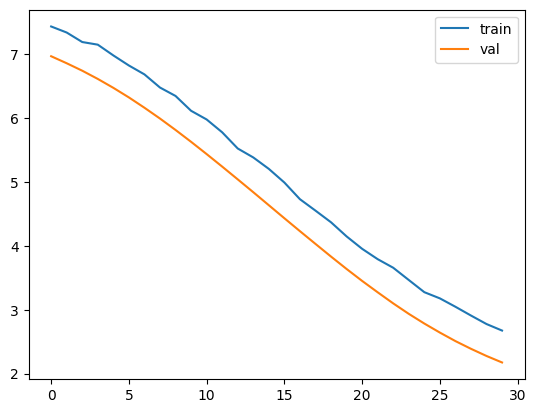

In [ ]:
#plot losses
plot_losses(train_loss_lora, val_loss_lora)

In [ ]:
#Compute test accuracy on MNIST 5...9 for that lora rank
accuracy_lora_subset2 = test(test_loader_subset2, "Testing lora on subset2 ", modified_net, {i: 0 for i in range(10)})

# We obtain an accuracy of 0.529 when lora_rank=1

Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 20.83it/s]

Accuracy: 0.529
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 399
Wrong counts for the digit 6: 715
Wrong counts for the digit 7: 243
Wrong counts for the digit 8: 778
Wrong counts for the digit 9: 153


# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

<font color='blue'> We first write a loop to fine-tune the pre-trained model using different lora ranks:

In [ ]:
ranks = [1,2,4,8,16,32,64]
# We store parameters losses in dictionnaries
test_accuracies = {}
num_parameters = {}

for lora_rank in ranks:
  print("-------------------------")
  print(f"Start training for rank {lora_rank}")
  modified_net = ModifiedClassifier(lora_rank).to(device)

  # Count parameters
  num = count_lora_parameters(modified_net)
  num_parameters[f'num_param_rank_{lora_rank}'] = num

  # Train and store test accuracies
  train_loss_lora, val_loss_lora = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=30)
  accuracy_lora_subset2 = test(test_loader_subset2, "Testing lora on subset2 ", modified_net, {i: 0 for i in range(10)})
  test_accuracies[f'test_accuracy_{lora_rank}'] = accuracy_lora_subset2

-------------------------
Start training for rank 1


Training: 100%|██████████| 161/161 [00:05<00:00, 29.14it/s, loss=7.83]


Epoch [1/30] Train Loss: 7.829472814287458


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.35it/s, loss=7.22]


Epoch [1/30] Validation Loss: 7.218422329944113


Training: 100%|██████████| 161/161 [00:05<00:00, 32.08it/s, loss=7.81]


Epoch [2/30] Train Loss: 7.813075610569546


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.52it/s, loss=7.16]


Epoch [2/30] Validation Loss: 7.158678345058275


Training: 100%|██████████| 161/161 [00:07<00:00, 22.86it/s, loss=7.73]


Epoch [3/30] Train Loss: 7.73143676497181


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.40it/s, loss=7.1]


Epoch [3/30] Validation Loss: 7.096836670585301


Training: 100%|██████████| 161/161 [00:05<00:00, 30.68it/s, loss=7.66]


Epoch [4/30] Train Loss: 7.663592770973348


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.87it/s, loss=7.03]


Epoch [4/30] Validation Loss: 7.02755746288576


Training: 100%|██████████| 161/161 [00:04<00:00, 32.35it/s, loss=7.56]


Epoch [5/30] Train Loss: 7.555543461201354


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.52it/s, loss=6.95]


Epoch [5/30] Validation Loss: 6.946710455244866


Training: 100%|██████████| 161/161 [00:05<00:00, 28.93it/s, loss=7.48]


Epoch [6/30] Train Loss: 7.475146512807526


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.95it/s, loss=6.85]


Epoch [6/30] Validation Loss: 6.850347180297409


Training: 100%|██████████| 161/161 [00:04<00:00, 32.95it/s, loss=7.39]


Epoch [7/30] Train Loss: 7.3883792569178235


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.18it/s, loss=6.74]


Epoch [7/30] Validation Loss: 6.736912229786748


Training: 100%|██████████| 161/161 [00:06<00:00, 25.33it/s, loss=7.24]


Epoch [8/30] Train Loss: 7.237705660162505


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.13it/s, loss=6.61]


Epoch [8/30] Validation Loss: 6.607373742089755


Training: 100%|██████████| 161/161 [00:05<00:00, 28.37it/s, loss=7.14]


Epoch [9/30] Train Loss: 7.141084043135554


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.23it/s, loss=6.46]


Epoch [9/30] Validation Loss: 6.459959472435108


Training: 100%|██████████| 161/161 [00:04<00:00, 32.93it/s, loss=6.92]


Epoch [10/30] Train Loss: 6.917682804676317


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.89it/s, loss=6.3]


Epoch [10/30] Validation Loss: 6.2983328708703965


Training: 100%|██████████| 161/161 [00:05<00:00, 27.59it/s, loss=6.72]


Epoch [11/30] Train Loss: 6.717347947707087


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.25it/s, loss=6.12]


Epoch [11/30] Validation Loss: 6.122202783391096


Training: 100%|██████████| 161/161 [00:05<00:00, 30.13it/s, loss=6.61]


Epoch [12/30] Train Loss: 6.60748723426961


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.24it/s, loss=5.93]


Epoch [12/30] Validation Loss: 5.934125603109166


Training: 100%|██████████| 161/161 [00:04<00:00, 32.20it/s, loss=6.39]


Epoch [13/30] Train Loss: 6.386579356578566


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.72it/s, loss=5.74]


Epoch [13/30] Validation Loss: 5.735543154288029


Training: 100%|██████████| 161/161 [00:06<00:00, 26.05it/s, loss=6.17]


Epoch [14/30] Train Loss: 6.165810703490832


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.11it/s, loss=5.53]


Epoch [14/30] Validation Loss: 5.528493722279866


Training: 100%|██████████| 161/161 [00:04<00:00, 32.58it/s, loss=5.94]


Epoch [15/30] Train Loss: 5.943324753956765


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.17it/s, loss=5.31]


Epoch [15/30] Validation Loss: 5.313114539436672


Training: 100%|██████████| 161/161 [00:04<00:00, 32.40it/s, loss=5.69]


Epoch [16/30] Train Loss: 5.693294887957365


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.16it/s, loss=5.09]


Epoch [16/30] Validation Loss: 5.092492058657218


Training: 100%|██████████| 161/161 [00:05<00:00, 28.44it/s, loss=5.48]


Epoch [17/30] Train Loss: 5.484884435345667


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.68it/s, loss=4.87]


Epoch [17/30] Validation Loss: 4.866382947866468


Training: 100%|██████████| 161/161 [00:05<00:00, 31.23it/s, loss=5.25]


Epoch [18/30] Train Loss: 5.250887716779057


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.35it/s, loss=4.64]


Epoch [18/30] Validation Loss: 4.6375463872716045


Training: 100%|██████████| 161/161 [00:05<00:00, 29.64it/s, loss=5.03]


Epoch [19/30] Train Loss: 5.0305642267191635


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.88it/s, loss=4.41]


Epoch [19/30] Validation Loss: 4.407216441804084


Training: 100%|██████████| 161/161 [00:05<00:00, 29.02it/s, loss=4.82]


Epoch [20/30] Train Loss: 4.822873687151796


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.06it/s, loss=4.18]


Epoch [20/30] Validation Loss: 4.1783788722494375


Training: 100%|██████████| 161/161 [00:05<00:00, 31.94it/s, loss=4.59]


Epoch [21/30] Train Loss: 4.5853681046029795


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.57it/s, loss=3.96]


Epoch [21/30] Validation Loss: 3.961457072824672


Training: 100%|██████████| 161/161 [00:05<00:00, 26.94it/s, loss=4.34]


Epoch [22/30] Train Loss: 4.342182406727572


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.16it/s, loss=3.75]


Epoch [22/30] Validation Loss: 3.752315476320792


Training: 100%|██████████| 161/161 [00:05<00:00, 31.58it/s, loss=4.15]


Epoch [23/30] Train Loss: 4.153443714106305


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.25it/s, loss=3.56]


Epoch [23/30] Validation Loss: 3.5568402366361758


Training: 100%|██████████| 161/161 [00:05<00:00, 31.80it/s, loss=3.97]


Epoch [24/30] Train Loss: 3.969837930631934


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.29it/s, loss=3.38]


Epoch [24/30] Validation Loss: 3.377538598102072


Training: 100%|██████████| 161/161 [00:05<00:00, 28.47it/s, loss=3.8]


Epoch [25/30] Train Loss: 3.803397608099517


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.46it/s, loss=3.21]


Epoch [25/30] Validation Loss: 3.2112970697707026


Training: 100%|██████████| 161/161 [00:05<00:00, 32.12it/s, loss=3.66]


Epoch [26/30] Train Loss: 3.6589356579395553


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.57it/s, loss=3.06]


Epoch [26/30] Validation Loss: 3.059205604636151


Training: 100%|██████████| 161/161 [00:05<00:00, 28.27it/s, loss=3.5]


Epoch [27/30] Train Loss: 3.498648206639734


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.42it/s, loss=2.92]


Epoch [27/30] Validation Loss: 2.919687081074369


Training: 100%|██████████| 161/161 [00:06<00:00, 24.03it/s, loss=3.4]


Epoch [28/30] Train Loss: 3.3960044769026476


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.69it/s, loss=2.79]


Epoch [28/30] Validation Loss: 2.791374659192735


Training: 100%|██████████| 161/161 [00:05<00:00, 32.19it/s, loss=3.26]


Epoch [29/30] Train Loss: 3.2550894740205374


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.43it/s, loss=2.67]


Epoch [29/30] Validation Loss: 2.673964930617291


Training: 100%|██████████| 161/161 [00:05<00:00, 28.18it/s, loss=3.15]


Epoch [30/30] Train Loss: 3.1491166641993553


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.29it/s, loss=2.56]


Epoch [30/30] Validation Loss: 2.5640934377476787


Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 29.47it/s]


Accuracy: 0.565
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 605
Wrong counts for the digit 6: 316
Wrong counts for the digit 7: 235
Wrong counts for the digit 8: 793
Wrong counts for the digit 9: 165
-------------------------
Start training for rank 2


Training: 100%|██████████| 161/161 [00:05<00:00, 27.64it/s, loss=7.81]


Epoch [1/30] Train Loss: 7.812282115035916


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.72it/s, loss=7.06]


Epoch [1/30] Validation Loss: 7.063415783039038


Training: 100%|██████████| 161/161 [00:04<00:00, 32.85it/s, loss=7.63]


Epoch [2/30] Train Loss: 7.6321164332561615


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.53it/s, loss=6.92]


Epoch [2/30] Validation Loss: 6.922883013020391


Training: 100%|██████████| 161/161 [00:05<00:00, 28.26it/s, loss=7.46]


Epoch [3/30] Train Loss: 7.457272944243058


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.73it/s, loss=6.78]


Epoch [3/30] Validation Loss: 6.779524049897125


Training: 100%|██████████| 161/161 [00:06<00:00, 25.98it/s, loss=7.32]


Epoch [4/30] Train Loss: 7.319363745102971


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.57it/s, loss=6.63]


Epoch [4/30] Validation Loss: 6.630293652631234


Training: 100%|██████████| 161/161 [00:05<00:00, 29.12it/s, loss=7.17]


Epoch [5/30] Train Loss: 7.165336401566215


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.34it/s, loss=6.47]


Epoch [5/30] Validation Loss: 6.470926913662233


Training: 100%|██████████| 161/161 [00:06<00:00, 26.29it/s, loss=6.99]


Epoch [6/30] Train Loss: 6.9900084074979985


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.20it/s, loss=6.3]


Epoch [6/30] Validation Loss: 6.295196194579636


Training: 100%|██████████| 161/161 [00:05<00:00, 28.14it/s, loss=6.78]


Epoch [7/30] Train Loss: 6.777442508602735


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.92it/s, loss=6.1]


Epoch [7/30] Validation Loss: 6.104933351710223


Training: 100%|██████████| 161/161 [00:05<00:00, 30.11it/s, loss=6.6]


Epoch [8/30] Train Loss: 6.598916767546849


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.36it/s, loss=5.9]


Epoch [8/30] Validation Loss: 5.896661689316017


Training: 100%|██████████| 161/161 [00:06<00:00, 25.96it/s, loss=6.37]


Epoch [9/30] Train Loss: 6.371313053628673


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.29it/s, loss=5.67]


Epoch [9/30] Validation Loss: 5.674367469290028


Training: 100%|██████████| 161/161 [00:05<00:00, 28.11it/s, loss=6.09]


Epoch [10/30] Train Loss: 6.085480121351917


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.07it/s, loss=5.44]


Epoch [10/30] Validation Loss: 5.436787864436274


Training: 100%|██████████| 161/161 [00:05<00:00, 29.92it/s, loss=5.88]


Epoch [11/30] Train Loss: 5.878042804528468


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.08it/s, loss=5.19]


Epoch [11/30] Validation Loss: 5.186522964118184


Training: 100%|██████████| 161/161 [00:05<00:00, 26.91it/s, loss=5.58]


Epoch [12/30] Train Loss: 5.58259520027208


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.40it/s, loss=4.92]


Epoch [12/30] Validation Loss: 4.918717342874278


Training: 100%|██████████| 161/161 [00:05<00:00, 30.03it/s, loss=5.3]


Epoch [13/30] Train Loss: 5.303236905092038


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.45it/s, loss=4.64]


Epoch [13/30] Validation Loss: 4.638800213302392


Training: 100%|██████████| 161/161 [00:05<00:00, 30.69it/s, loss=5.02]


Epoch [14/30] Train Loss: 5.022002100204089


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.97it/s, loss=4.35]


Epoch [14/30] Validation Loss: 4.3450486107148985


Training: 100%|██████████| 161/161 [00:05<00:00, 27.24it/s, loss=4.71]


Epoch [15/30] Train Loss: 4.711613464059297


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.39it/s, loss=4.04]


Epoch [15/30] Validation Loss: 4.041296285131703


Training: 100%|██████████| 161/161 [00:06<00:00, 26.21it/s, loss=4.41]


Epoch [16/30] Train Loss: 4.411233906420121


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.38it/s, loss=3.73]


Epoch [16/30] Validation Loss: 3.7302005912946616


Training: 100%|██████████| 161/161 [00:05<00:00, 30.73it/s, loss=4.12]


Epoch [17/30] Train Loss: 4.116728908526971


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.13it/s, loss=3.43]


Epoch [17/30] Validation Loss: 3.4253647638403852


Training: 100%|██████████| 161/161 [00:05<00:00, 27.11it/s, loss=3.83]


Epoch [18/30] Train Loss: 3.8260055358365457


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.17it/s, loss=3.13]


Epoch [18/30] Validation Loss: 3.1272684249325073


Training: 100%|██████████| 161/161 [00:05<00:00, 30.24it/s, loss=3.53]


Epoch [19/30] Train Loss: 3.5255388724877967


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.46it/s, loss=2.85]


Epoch [19/30] Validation Loss: 2.8511911734290747


Training: 100%|██████████| 161/161 [00:05<00:00, 30.05it/s, loss=3.24]


Epoch [20/30] Train Loss: 3.24196826226963


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.95it/s, loss=2.6]


Epoch [20/30] Validation Loss: 2.6045091998749883


Training: 100%|██████████| 161/161 [00:05<00:00, 28.86it/s, loss=3.03]


Epoch [21/30] Train Loss: 3.034441577721827


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.65it/s, loss=2.39]


Epoch [21/30] Validation Loss: 2.3850935265637827


Training: 100%|██████████| 161/161 [00:04<00:00, 32.38it/s, loss=2.84]


Epoch [22/30] Train Loss: 2.841505299443784


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.81it/s, loss=2.19]


Epoch [22/30] Validation Loss: 2.1929700063622515


Training: 100%|██████████| 161/161 [00:05<00:00, 29.46it/s, loss=2.63]


Epoch [23/30] Train Loss: 2.627956884247916


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.95it/s, loss=2.03]


Epoch [23/30] Validation Loss: 2.0275716729786084


Training: 100%|██████████| 161/161 [00:05<00:00, 28.58it/s, loss=2.49]


Epoch [24/30] Train Loss: 2.4949498132148884


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.92it/s, loss=1.89]


Epoch [24/30] Validation Loss: 1.8883662724840469


Training: 100%|██████████| 161/161 [00:04<00:00, 32.29it/s, loss=2.35]


Epoch [25/30] Train Loss: 2.348382604788549


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.95it/s, loss=1.77]


Epoch [25/30] Validation Loss: 1.7662352617236152


Training: 100%|██████████| 161/161 [00:05<00:00, 28.35it/s, loss=2.24]


Epoch [26/30] Train Loss: 2.238648958828138


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.44it/s, loss=1.66]


Epoch [26/30] Validation Loss: 1.65883765877157


Training: 100%|██████████| 161/161 [00:04<00:00, 32.34it/s, loss=2.12]


Epoch [27/30] Train Loss: 2.1167219647709627


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.79it/s, loss=1.57]


Epoch [27/30] Validation Loss: 1.5665901640187139


Training: 100%|██████████| 161/161 [00:05<00:00, 30.78it/s, loss=2.01]


Epoch [28/30] Train Loss: 2.0054058643601698


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.81it/s, loss=1.48]


Epoch [28/30] Validation Loss: 1.4849154914634815


Training: 100%|██████████| 161/161 [00:05<00:00, 28.53it/s, loss=1.95]


Epoch [29/30] Train Loss: 1.9461269171341606


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.54it/s, loss=1.41]


Epoch [29/30] Validation Loss: 1.4112873975781426


Training: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s, loss=1.84]


Epoch [30/30] Train Loss: 1.8411676691185614


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.88it/s, loss=1.35]


Epoch [30/30] Validation Loss: 1.346100321714429


Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 23.29it/s]


Accuracy: 0.626
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 467
Wrong counts for the digit 6: 212
Wrong counts for the digit 7: 183
Wrong counts for the digit 8: 790
Wrong counts for the digit 9: 166
-------------------------
Start training for rank 4


Training: 100%|██████████| 161/161 [00:05<00:00, 31.06it/s, loss=7.69]


Epoch [1/30] Train Loss: 7.692246096474784


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.94it/s, loss=6.85]


Epoch [1/30] Validation Loss: 6.8470437975897305


Training: 100%|██████████| 161/161 [00:05<00:00, 27.30it/s, loss=7.23]


Epoch [2/30] Train Loss: 7.22970704262301


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.54it/s, loss=6.41]


Epoch [2/30] Validation Loss: 6.414834285127943


Training: 100%|██████████| 161/161 [00:05<00:00, 32.02it/s, loss=6.8]


Epoch [3/30] Train Loss: 6.798641782369673


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.42it/s, loss=5.98]


Epoch [3/30] Validation Loss: 5.9783912810726445


Training: 100%|██████████| 161/161 [00:05<00:00, 28.32it/s, loss=6.29]


Epoch [4/30] Train Loss: 6.286094052450998


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.33it/s, loss=5.52]


Epoch [4/30] Validation Loss: 5.523694936779962


Training: 100%|██████████| 161/161 [00:05<00:00, 31.34it/s, loss=5.82]


Epoch [5/30] Train Loss: 5.817304830373444


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.71it/s, loss=5.05]


Epoch [5/30] Validation Loss: 5.054563819498256


Training: 100%|██████████| 161/161 [00:05<00:00, 31.24it/s, loss=5.29]


Epoch [6/30] Train Loss: 5.285459392559455


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.61it/s, loss=4.57]


Epoch [6/30] Validation Loss: 4.574204628018365


Training: 100%|██████████| 161/161 [00:05<00:00, 28.48it/s, loss=4.76]


Epoch [7/30] Train Loss: 4.757047115645793


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.82it/s, loss=4.09]


Epoch [7/30] Validation Loss: 4.089007422543954


Training: 100%|██████████| 161/161 [00:05<00:00, 31.63it/s, loss=4.31]


Epoch [8/30] Train Loss: 4.310648531647202


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.16it/s, loss=3.6]


Epoch [8/30] Validation Loss: 3.5993234178294307


Training: 100%|██████████| 161/161 [00:05<00:00, 30.19it/s, loss=3.79]


Epoch [9/30] Train Loss: 3.786848971562356


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.89it/s, loss=3.14]


Epoch [9/30] Validation Loss: 3.1364081147788228


Training: 100%|██████████| 161/161 [00:05<00:00, 27.45it/s, loss=3.4]


Epoch [10/30] Train Loss: 3.4016354513464506


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.74it/s, loss=2.71]


Epoch [10/30] Validation Loss: 2.714755538581074


Training: 100%|██████████| 161/161 [00:04<00:00, 32.56it/s, loss=3]


Epoch [11/30] Train Loss: 2.9956969526243507


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.60it/s, loss=2.35]


Epoch [11/30] Validation Loss: 2.3504491871681767


Training: 100%|██████████| 161/161 [00:05<00:00, 28.28it/s, loss=2.68]


Epoch [12/30] Train Loss: 2.6831526326837007


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.48it/s, loss=2.04]


Epoch [12/30] Validation Loss: 2.0374025590177895


Training: 100%|██████████| 161/161 [00:05<00:00, 31.76it/s, loss=2.42]


Epoch [13/30] Train Loss: 2.4156809497323835


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.40it/s, loss=1.78]


Epoch [13/30] Validation Loss: 1.7765015864717788


Training: 100%|██████████| 161/161 [00:05<00:00, 31.36it/s, loss=2.17]


Epoch [14/30] Train Loss: 2.169832842690604


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.52it/s, loss=1.57]


Epoch [14/30] Validation Loss: 1.5653859169586846


Training: 100%|██████████| 161/161 [00:05<00:00, 27.85it/s, loss=1.98]


Epoch [15/30] Train Loss: 1.984132985150592


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.15it/s, loss=1.4]


Epoch [15/30] Validation Loss: 1.4025664338167163


Training: 100%|██████████| 161/161 [00:05<00:00, 30.57it/s, loss=1.85]


Epoch [16/30] Train Loss: 1.8472773902904913


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.04it/s, loss=1.27]


Epoch [16/30] Validation Loss: 1.2726653589718584


Training: 100%|██████████| 161/161 [00:05<00:00, 29.93it/s, loss=1.7]


Epoch [17/30] Train Loss: 1.701901804586375


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.84it/s, loss=1.17]


Epoch [17/30] Validation Loss: 1.168794308019721


Training: 100%|██████████| 161/161 [00:05<00:00, 27.50it/s, loss=1.6]


Epoch [18/30] Train Loss: 1.6009069773721398


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.18it/s, loss=1.08]


Epoch [18/30] Validation Loss: 1.0833139505939207


Training: 100%|██████████| 161/161 [00:05<00:00, 31.52it/s, loss=1.51]


Epoch [19/30] Train Loss: 1.5116016235410796


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.94it/s, loss=1.01]


Epoch [19/30] Validation Loss: 1.0139113224071006


Training: 100%|██████████| 161/161 [00:06<00:00, 25.77it/s, loss=1.44]


Epoch [20/30] Train Loss: 1.4384128740115196


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.03it/s, loss=0.953]


Epoch [20/30] Validation Loss: 0.9533397589904674


Training: 100%|██████████| 161/161 [00:05<00:00, 30.21it/s, loss=1.36]


Epoch [21/30] Train Loss: 1.3618861355396532


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.52it/s, loss=0.9]


Epoch [21/30] Validation Loss: 0.9001228187395178


Training: 100%|██████████| 161/161 [00:05<00:00, 29.62it/s, loss=1.31]


Epoch [22/30] Train Loss: 1.3111460116339027


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.64it/s, loss=0.853]


Epoch [22/30] Validation Loss: 0.8533854778262152


Training: 100%|██████████| 161/161 [00:05<00:00, 27.83it/s, loss=1.26]


Epoch [23/30] Train Loss: 1.256735402234593


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.63it/s, loss=0.813]


Epoch [23/30] Validation Loss: 0.8132822815922723


Training: 100%|██████████| 161/161 [00:05<00:00, 31.63it/s, loss=1.2]


Epoch [24/30] Train Loss: 1.199957996051504


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.89it/s, loss=0.777]


Epoch [24/30] Validation Loss: 0.7767077256803927


Training: 100%|██████████| 161/161 [00:05<00:00, 31.67it/s, loss=1.16]


Epoch [25/30] Train Loss: 1.1643746250904865


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.10it/s, loss=0.745]


Epoch [25/30] Validation Loss: 0.7447666452414747


Training: 100%|██████████| 161/161 [00:05<00:00, 27.15it/s, loss=1.12]


Epoch [26/30] Train Loss: 1.1184800552285237


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.09it/s, loss=0.715]


Epoch [26/30] Validation Loss: 0.7146368303160736


Training: 100%|██████████| 161/161 [00:05<00:00, 31.44it/s, loss=1.08]


Epoch [27/30] Train Loss: 1.0790261045005751


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.68it/s, loss=0.688]


Epoch [27/30] Validation Loss: 0.6877172757749972


Training: 100%|██████████| 161/161 [00:05<00:00, 28.60it/s, loss=1.07]


Epoch [28/30] Train Loss: 1.0661141257848799


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.71it/s, loss=0.664]


Epoch [28/30] Validation Loss: 0.6637582778930664


Training: 100%|██████████| 161/161 [00:05<00:00, 28.34it/s, loss=1.02]


Epoch [29/30] Train Loss: 1.021331733057958


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.70it/s, loss=0.641]


Epoch [29/30] Validation Loss: 0.6407286585241124


Training: 100%|██████████| 161/161 [00:05<00:00, 29.28it/s, loss=0.983]


Epoch [30/30] Train Loss: 0.9827952447885312


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.31it/s, loss=0.62]


Epoch [30/30] Validation Loss: 0.6200919298158176


Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 24.81it/s]


Accuracy: 0.832
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 163
Wrong counts for the digit 6: 52
Wrong counts for the digit 7: 152
Wrong counts for the digit 8: 299
Wrong counts for the digit 9: 153
-------------------------
Start training for rank 8


Training: 100%|██████████| 161/161 [00:05<00:00, 29.29it/s, loss=7.11]


Epoch [1/30] Train Loss: 7.1103224695099065


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.17it/s, loss=6.11]


Epoch [1/30] Validation Loss: 6.109523192695949


Training: 100%|██████████| 161/161 [00:05<00:00, 27.25it/s, loss=6.26]


Epoch [2/30] Train Loss: 6.257770668645823


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.64it/s, loss=5.37]


Epoch [2/30] Validation Loss: 5.368116917817489


Training: 100%|██████████| 161/161 [00:05<00:00, 31.14it/s, loss=5.49]


Epoch [3/30] Train Loss: 5.49495538125127


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.12it/s, loss=4.65]


Epoch [3/30] Validation Loss: 4.64726438038591


Training: 100%|██████████| 161/161 [00:05<00:00, 27.66it/s, loss=4.81]


Epoch [4/30] Train Loss: 4.808625712898207


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.48it/s, loss=3.95]


Epoch [4/30] Validation Loss: 3.9462594087573066


Training: 100%|██████████| 161/161 [00:05<00:00, 28.85it/s, loss=4.14]


Epoch [5/30] Train Loss: 4.136618049988836


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.67it/s, loss=3.28]


Epoch [5/30] Validation Loss: 3.278078048125557


Training: 100%|██████████| 161/161 [00:05<00:00, 31.22it/s, loss=3.5]


Epoch [6/30] Train Loss: 3.496676094043329


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.14it/s, loss=2.7]


Epoch [6/30] Validation Loss: 2.698584086653115


Training: 100%|██████████| 161/161 [00:05<00:00, 27.75it/s, loss=2.97]


Epoch [7/30] Train Loss: 2.973321297153923


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.38it/s, loss=2.23]


Epoch [7/30] Validation Loss: 2.2252901757972827


Training: 100%|██████████| 161/161 [00:05<00:00, 31.65it/s, loss=2.59]


Epoch [8/30] Train Loss: 2.5945354448342175


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.30it/s, loss=1.88]


Epoch [8/30] Validation Loss: 1.8765518613483594


Training: 100%|██████████| 161/161 [00:05<00:00, 31.07it/s, loss=2.31]


Epoch [9/30] Train Loss: 2.3051414030679265


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.58it/s, loss=1.64]


Epoch [9/30] Validation Loss: 1.6360888221989507


Training: 100%|██████████| 161/161 [00:05<00:00, 27.59it/s, loss=2.09]


Epoch [10/30] Train Loss: 2.085356133324759


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.75it/s, loss=1.46]


Epoch [10/30] Validation Loss: 1.4595068123029626


Training: 100%|██████████| 161/161 [00:05<00:00, 31.56it/s, loss=1.9]


Epoch [11/30] Train Loss: 1.903963579894593


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.20it/s, loss=1.33]


Epoch [11/30] Validation Loss: 1.3255298206771629


Training: 100%|██████████| 161/161 [00:05<00:00, 30.28it/s, loss=1.74]


Epoch [12/30] Train Loss: 1.742394841235617


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.91it/s, loss=1.21]


Epoch [12/30] Validation Loss: 1.2136286410732546


Training: 100%|██████████| 161/161 [00:05<00:00, 27.54it/s, loss=1.64]


Epoch [13/30] Train Loss: 1.64067422455142


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.10it/s, loss=1.12]


Epoch [13/30] Validation Loss: 1.118014919585076


Training: 100%|██████████| 161/161 [00:05<00:00, 31.52it/s, loss=1.52]


Epoch [14/30] Train Loss: 1.5184580039533768


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.31it/s, loss=1.03]


Epoch [14/30] Validation Loss: 1.0341836024021758


Training: 100%|██████████| 161/161 [00:05<00:00, 27.17it/s, loss=1.42]


Epoch [15/30] Train Loss: 1.4165522034123819


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.96it/s, loss=0.961]


Epoch [15/30] Validation Loss: 0.9607456352399744


Training: 100%|██████████| 161/161 [00:05<00:00, 28.95it/s, loss=1.33]


Epoch [16/30] Train Loss: 1.3285142124069402


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.28it/s, loss=0.895]


Epoch [16/30] Validation Loss: 0.8946886978287628


Training: 100%|██████████| 161/161 [00:05<00:00, 31.50it/s, loss=1.25]


Epoch [17/30] Train Loss: 1.2524116416895612


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.82it/s, loss=0.835]


Epoch [17/30] Validation Loss: 0.8350617816482765


Training: 100%|██████████| 161/161 [00:05<00:00, 27.85it/s, loss=1.19]


Epoch [18/30] Train Loss: 1.1859227833540544


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.97it/s, loss=0.783]


Epoch [18/30] Validation Loss: 0.7832405752893807


Training: 100%|██████████| 161/161 [00:05<00:00, 31.33it/s, loss=1.13]


Epoch [19/30] Train Loss: 1.1282378568412355


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.87it/s, loss=0.733]


Epoch [19/30] Validation Loss: 0.7334244531997736


Training: 100%|██████████| 161/161 [00:05<00:00, 31.35it/s, loss=1.07]


Epoch [20/30] Train Loss: 1.0697765083786863


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.96it/s, loss=0.688]


Epoch [20/30] Validation Loss: 0.6881394204886063


Training: 100%|██████████| 161/161 [00:05<00:00, 27.82it/s, loss=1.01]


Epoch [21/30] Train Loss: 1.0140756983194292


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.78it/s, loss=0.651]


Epoch [21/30] Validation Loss: 0.6506358791088712


Training: 100%|██████████| 161/161 [00:05<00:00, 30.32it/s, loss=0.971]


Epoch [22/30] Train Loss: 0.9711216073598921


Validation: 100%|██████████| 69/69 [00:03<00:00, 22.90it/s, loss=0.615]


Epoch [22/30] Validation Loss: 0.6148185945939326


Training: 100%|██████████| 161/161 [00:05<00:00, 28.18it/s, loss=0.914]


Epoch [23/30] Train Loss: 0.9142718383614321


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.20it/s, loss=0.582]


Epoch [23/30] Validation Loss: 0.5818429153034652


Training: 100%|██████████| 161/161 [00:05<00:00, 27.32it/s, loss=0.864]


Epoch [24/30] Train Loss: 0.8637745572913508


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.76it/s, loss=0.553]


Epoch [24/30] Validation Loss: 0.5528058478797692


Training: 100%|██████████| 161/161 [00:05<00:00, 31.14it/s, loss=0.837]


Epoch [25/30] Train Loss: 0.8372767771252935


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.08it/s, loss=0.523]


Epoch [25/30] Validation Loss: 0.5232308895691581


Training: 100%|██████████| 161/161 [00:05<00:00, 27.74it/s, loss=0.807]


Epoch [26/30] Train Loss: 0.8073063959246096


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.75it/s, loss=0.5]


Epoch [26/30] Validation Loss: 0.5003868682660918


Training: 100%|██████████| 161/161 [00:05<00:00, 27.96it/s, loss=0.752]


Epoch [27/30] Train Loss: 0.7524463234480864


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.84it/s, loss=0.479]


Epoch [27/30] Validation Loss: 0.4786656287269316


Training: 100%|██████████| 161/161 [00:05<00:00, 30.88it/s, loss=0.753]


Epoch [28/30] Train Loss: 0.7528525851898312


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.53it/s, loss=0.457]


Epoch [28/30] Validation Loss: 0.45653870852961054


Training: 100%|██████████| 161/161 [00:05<00:00, 26.99it/s, loss=0.717]


Epoch [29/30] Train Loss: 0.7166820377666757


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.09it/s, loss=0.438]


Epoch [29/30] Validation Loss: 0.4375218045020449


Training: 100%|██████████| 161/161 [00:05<00:00, 30.04it/s, loss=0.689]


Epoch [30/30] Train Loss: 0.6887855265081299


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.98it/s, loss=0.419]


Epoch [30/30] Validation Loss: 0.4190232419017432


Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 28.88it/s]


Accuracy: 0.893
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 127
Wrong counts for the digit 6: 46
Wrong counts for the digit 7: 132
Wrong counts for the digit 8: 137
Wrong counts for the digit 9: 77
-------------------------
Start training for rank 16


Training: 100%|██████████| 161/161 [00:05<00:00, 30.69it/s, loss=7.09]


Epoch [1/30] Train Loss: 7.085368636231985


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.34it/s, loss=5.96]


Epoch [1/30] Validation Loss: 5.956562940625177


Training: 100%|██████████| 161/161 [00:05<00:00, 27.02it/s, loss=5.95]


Epoch [2/30] Train Loss: 5.95377194363138


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.72it/s, loss=4.98]


Epoch [2/30] Validation Loss: 4.981342370959296


Training: 100%|██████████| 161/161 [00:05<00:00, 28.40it/s, loss=5]


Epoch [3/30] Train Loss: 5.0032727436989735


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.17it/s, loss=4.06]


Epoch [3/30] Validation Loss: 4.058025425758915


Training: 100%|██████████| 161/161 [00:05<00:00, 30.42it/s, loss=4.03]


Epoch [4/30] Train Loss: 4.033079375391421


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.62it/s, loss=3.18]


Epoch [4/30] Validation Loss: 3.1847240371980527


Training: 100%|██████████| 161/161 [00:05<00:00, 26.94it/s, loss=3.17]


Epoch [5/30] Train Loss: 3.173014015884873


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.87it/s, loss=2.39]


Epoch [5/30] Validation Loss: 2.392589289209117


Training: 100%|██████████| 161/161 [00:05<00:00, 29.27it/s, loss=2.53]


Epoch [6/30] Train Loss: 2.528606565102287


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.88it/s, loss=1.78]


Epoch [6/30] Validation Loss: 1.7823651752610137


Training: 100%|██████████| 161/161 [00:05<00:00, 30.31it/s, loss=2.06]


Epoch [7/30] Train Loss: 2.056211102823293


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.76it/s, loss=1.41]


Epoch [7/30] Validation Loss: 1.4062699407771013


Training: 100%|██████████| 161/161 [00:06<00:00, 26.43it/s, loss=1.73]


Epoch [8/30] Train Loss: 1.7324152363013037


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.06it/s, loss=1.18]


Epoch [8/30] Validation Loss: 1.1825483968292458


Training: 100%|██████████| 161/161 [00:05<00:00, 30.27it/s, loss=1.56]


Epoch [9/30] Train Loss: 1.5591837389868979


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.80it/s, loss=1.02]


Epoch [9/30] Validation Loss: 1.023539850677269


Training: 100%|██████████| 161/161 [00:05<00:00, 30.21it/s, loss=1.39]


Epoch [10/30] Train Loss: 1.394747479361777


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.20it/s, loss=0.904]


Epoch [10/30] Validation Loss: 0.9043892120969468


Training: 100%|██████████| 161/161 [00:05<00:00, 26.98it/s, loss=1.25]


Epoch [11/30] Train Loss: 1.2535030305015376


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.04it/s, loss=0.807]


Epoch [11/30] Validation Loss: 0.8072232923645905


Training: 100%|██████████| 161/161 [00:05<00:00, 29.51it/s, loss=1.12]


Epoch [12/30] Train Loss: 1.1222520500236417


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.81it/s, loss=0.728]


Epoch [12/30] Validation Loss: 0.7280485923739447


Training: 100%|██████████| 161/161 [00:05<00:00, 29.69it/s, loss=1.05]


Epoch [13/30] Train Loss: 1.048509300865742


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.23it/s, loss=0.662]


Epoch [13/30] Validation Loss: 0.6615878321986267


Training: 100%|██████████| 161/161 [00:06<00:00, 26.77it/s, loss=0.959]


Epoch [14/30] Train Loss: 0.959401660083984


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.42it/s, loss=0.607]


Epoch [14/30] Validation Loss: 0.6065077755762183


Training: 100%|██████████| 161/161 [00:05<00:00, 30.15it/s, loss=0.907]


Epoch [15/30] Train Loss: 0.9072134683591239


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.13it/s, loss=0.561]


Epoch [15/30] Validation Loss: 0.5610052005968232


Training: 100%|██████████| 161/161 [00:05<00:00, 27.88it/s, loss=0.848]


Epoch [16/30] Train Loss: 0.848204081102928


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.90it/s, loss=0.52]


Epoch [16/30] Validation Loss: 0.5201582856800245


Training: 100%|██████████| 161/161 [00:06<00:00, 26.66it/s, loss=0.796]


Epoch [17/30] Train Loss: 0.7958659566707492


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.82it/s, loss=0.485]


Epoch [17/30] Validation Loss: 0.4849344779183899


Training: 100%|██████████| 161/161 [00:05<00:00, 30.17it/s, loss=0.757]


Epoch [18/30] Train Loss: 0.757196537456157


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.45it/s, loss=0.455]


Epoch [18/30] Validation Loss: 0.4550005625123563


Training: 100%|██████████| 161/161 [00:05<00:00, 27.65it/s, loss=0.707]


Epoch [19/30] Train Loss: 0.706583814776462


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.27it/s, loss=0.429]


Epoch [19/30] Validation Loss: 0.4291258223246837


Training: 100%|██████████| 161/161 [00:06<00:00, 25.86it/s, loss=0.679]


Epoch [20/30] Train Loss: 0.6791920513840195


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.66it/s, loss=0.404]


Epoch [20/30] Validation Loss: 0.40369856033636176


Training: 100%|██████████| 161/161 [00:05<00:00, 29.92it/s, loss=0.634]


Epoch [21/30] Train Loss: 0.6340037445474115


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.83it/s, loss=0.382]


Epoch [21/30] Validation Loss: 0.3818705671507379


Training: 100%|██████████| 161/161 [00:05<00:00, 27.01it/s, loss=0.607]


Epoch [22/30] Train Loss: 0.6070214474793547


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.13it/s, loss=0.362]


Epoch [22/30] Validation Loss: 0.3616407168084297


Training: 100%|██████████| 161/161 [00:05<00:00, 27.27it/s, loss=0.58]


Epoch [23/30] Train Loss: 0.5795368665123578


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.13it/s, loss=0.344]


Epoch [23/30] Validation Loss: 0.34436684566131537


Training: 100%|██████████| 161/161 [00:05<00:00, 28.49it/s, loss=0.547]


Epoch [24/30] Train Loss: 0.5474876911373612


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.67it/s, loss=0.326]


Epoch [24/30] Validation Loss: 0.3260535142128018


Training: 100%|██████████| 161/161 [00:05<00:00, 28.04it/s, loss=0.529]


Epoch [25/30] Train Loss: 0.528510006873504


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.13it/s, loss=0.309]


Epoch [25/30] Validation Loss: 0.30949189913445624


Training: 100%|██████████| 161/161 [00:06<00:00, 26.56it/s, loss=0.499]


Epoch [26/30] Train Loss: 0.4991832549527565


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.72it/s, loss=0.294]


Epoch [26/30] Validation Loss: 0.2942637725584749


Training: 100%|██████████| 161/161 [00:05<00:00, 29.30it/s, loss=0.477]


Epoch [27/30] Train Loss: 0.4770339075823008


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.16it/s, loss=0.28]


Epoch [27/30] Validation Loss: 0.2804269233475561


Training: 100%|██████████| 161/161 [00:05<00:00, 26.92it/s, loss=0.461]


Epoch [28/30] Train Loss: 0.46138296845536797


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.94it/s, loss=0.268]


Epoch [28/30] Validation Loss: 0.26836067902437155


Training: 100%|██████████| 161/161 [00:06<00:00, 26.43it/s, loss=0.436]


Epoch [29/30] Train Loss: 0.4357184806595678


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.71it/s, loss=0.256]


Epoch [29/30] Validation Loss: 0.25586366221524665


Training: 100%|██████████| 161/161 [00:05<00:00, 29.85it/s, loss=0.429]


Epoch [30/30] Train Loss: 0.42866925747128004


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.59it/s, loss=0.246]


Epoch [30/30] Validation Loss: 0.24588473119597504


Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 21.34it/s]


Accuracy: 0.928
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 77
Wrong counts for the digit 6: 22
Wrong counts for the digit 7: 50
Wrong counts for the digit 8: 124
Wrong counts for the digit 9: 78
-------------------------
Start training for rank 32


Training: 100%|██████████| 161/161 [00:05<00:00, 27.96it/s, loss=7.45]


Epoch [1/30] Train Loss: 7.451688911603845


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.17it/s, loss=5.84]


Epoch [1/30] Validation Loss: 5.835105481355087


Training: 100%|██████████| 161/161 [00:06<00:00, 26.15it/s, loss=5.45]


Epoch [2/30] Train Loss: 5.447657016493519


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.06it/s, loss=4.08]


Epoch [2/30] Validation Loss: 4.08303715871728


Training: 100%|██████████| 161/161 [00:05<00:00, 29.88it/s, loss=3.8]


Epoch [3/30] Train Loss: 3.7955466486652445


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.30it/s, loss=2.6]


Epoch [3/30] Validation Loss: 2.595810838367628


Training: 100%|██████████| 161/161 [00:05<00:00, 29.18it/s, loss=2.62]


Epoch [4/30] Train Loss: 2.6247189829808586


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.81it/s, loss=1.68]


Epoch [4/30] Validation Loss: 1.6839437277420708


Training: 100%|██████████| 161/161 [00:06<00:00, 26.21it/s, loss=2]


Epoch [5/30] Train Loss: 2.0017955836302006


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.83it/s, loss=1.24]


Epoch [5/30] Validation Loss: 1.2436680284099302


Training: 100%|██████████| 161/161 [00:05<00:00, 29.74it/s, loss=1.65]


Epoch [6/30] Train Loss: 1.6517319116533173


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.77it/s, loss=0.979]


Epoch [6/30] Validation Loss: 0.9788995696150739


Training: 100%|██████████| 161/161 [00:05<00:00, 28.57it/s, loss=1.37]


Epoch [7/30] Train Loss: 1.3701892458133815


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.19it/s, loss=0.804]


Epoch [7/30] Validation Loss: 0.8039169924846594


Training: 100%|██████████| 161/161 [00:06<00:00, 26.43it/s, loss=1.17]


Epoch [8/30] Train Loss: 1.1719337342688756


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.90it/s, loss=0.68]


Epoch [8/30] Validation Loss: 0.6797150066797284


Training: 100%|██████████| 161/161 [00:05<00:00, 30.13it/s, loss=1.06]


Epoch [9/30] Train Loss: 1.0641855534559452


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.85it/s, loss=0.59]


Epoch [9/30] Validation Loss: 0.5897649880768596


Training: 100%|██████████| 161/161 [00:05<00:00, 28.14it/s, loss=0.919]


Epoch [10/30] Train Loss: 0.9189509941924433


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.25it/s, loss=0.525]


Epoch [10/30] Validation Loss: 0.5252069070719291


Training: 100%|██████████| 161/161 [00:06<00:00, 26.68it/s, loss=0.829]


Epoch [11/30] Train Loss: 0.8290013263684622


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.82it/s, loss=0.466]


Epoch [11/30] Validation Loss: 0.4662899426791979


Training: 100%|██████████| 161/161 [00:05<00:00, 30.00it/s, loss=0.77]


Epoch [12/30] Train Loss: 0.7704967053040214


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.85it/s, loss=0.422]


Epoch [12/30] Validation Loss: 0.4216107168923254


Training: 100%|██████████| 161/161 [00:06<00:00, 26.09it/s, loss=0.702]


Epoch [13/30] Train Loss: 0.7021364978751781


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.70it/s, loss=0.386]


Epoch [13/30] Validation Loss: 0.38627903832905536


Training: 100%|██████████| 161/161 [00:05<00:00, 27.07it/s, loss=0.654]


Epoch [14/30] Train Loss: 0.6540166195134939


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.22it/s, loss=0.354]


Epoch [14/30] Validation Loss: 0.3543318063020706


Training: 100%|██████████| 161/161 [00:05<00:00, 30.13it/s, loss=0.612]


Epoch [15/30] Train Loss: 0.6115617487371338


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.09it/s, loss=0.327]


Epoch [15/30] Validation Loss: 0.32655200664547906


Training: 100%|██████████| 161/161 [00:06<00:00, 26.08it/s, loss=0.571]


Epoch [16/30] Train Loss: 0.5713303103950453


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.97it/s, loss=0.306]


Epoch [16/30] Validation Loss: 0.3055019685323688


Training: 100%|██████████| 161/161 [00:05<00:00, 27.04it/s, loss=0.537]


Epoch [17/30] Train Loss: 0.5365767695518754


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.80it/s, loss=0.288]


Epoch [17/30] Validation Loss: 0.28756641240223596


Training: 100%|██████████| 161/161 [00:05<00:00, 30.02it/s, loss=0.503]


Epoch [18/30] Train Loss: 0.5031272322865006


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.16it/s, loss=0.269]


Epoch [18/30] Validation Loss: 0.269296161506487


Training: 100%|██████████| 161/161 [00:06<00:00, 26.23it/s, loss=0.47]


Epoch [19/30] Train Loss: 0.4702282246225369


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.68it/s, loss=0.255]


Epoch [19/30] Validation Loss: 0.2552837969168373


Training: 100%|██████████| 161/161 [00:06<00:00, 25.86it/s, loss=0.45]


Epoch [20/30] Train Loss: 0.4497729977650672


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.71it/s, loss=0.241]


Epoch [20/30] Validation Loss: 0.2409872440756231


Training: 100%|██████████| 161/161 [00:05<00:00, 29.22it/s, loss=0.427]


Epoch [21/30] Train Loss: 0.4267549087171969


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.38it/s, loss=0.228]


Epoch [21/30] Validation Loss: 0.2280386323514192


Training: 100%|██████████| 161/161 [00:06<00:00, 26.53it/s, loss=0.416]


Epoch [22/30] Train Loss: 0.4162722739928998


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.76it/s, loss=0.216]


Epoch [22/30] Validation Loss: 0.21587437229311984


Training: 100%|██████████| 161/161 [00:06<00:00, 26.71it/s, loss=0.399]


Epoch [23/30] Train Loss: 0.39885660024903574


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.81it/s, loss=0.206]


Epoch [23/30] Validation Loss: 0.20637921384279279


Training: 100%|██████████| 161/161 [00:05<00:00, 29.61it/s, loss=0.391]


Epoch [24/30] Train Loss: 0.39141335639153946


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.96it/s, loss=0.198]


Epoch [24/30] Validation Loss: 0.19774443224288415


Training: 100%|██████████| 161/161 [00:06<00:00, 26.33it/s, loss=0.357]


Epoch [25/30] Train Loss: 0.3569942507314386


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.00it/s, loss=0.19]


Epoch [25/30] Validation Loss: 0.18985436338445413


Training: 100%|██████████| 161/161 [00:06<00:00, 23.82it/s, loss=0.34]


Epoch [26/30] Train Loss: 0.339779149671519


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.11it/s, loss=0.184]


Epoch [26/30] Validation Loss: 0.18356083052745764


Training: 100%|██████████| 161/161 [00:05<00:00, 28.66it/s, loss=0.33]


Epoch [27/30] Train Loss: 0.3297398490194949


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.00it/s, loss=0.176]


Epoch [27/30] Validation Loss: 0.17576982080936432


Training: 100%|██████████| 161/161 [00:06<00:00, 26.02it/s, loss=0.317]


Epoch [28/30] Train Loss: 0.31679473225004184


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.72it/s, loss=0.17]


Epoch [28/30] Validation Loss: 0.1695379297370496


Training: 100%|██████████| 161/161 [00:05<00:00, 27.05it/s, loss=0.316]


Epoch [29/30] Train Loss: 0.31559485322014885


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.96it/s, loss=0.166]


Epoch [29/30] Validation Loss: 0.16568185820959616


Training: 100%|██████████| 161/161 [00:05<00:00, 29.28it/s, loss=0.296]


Epoch [30/30] Train Loss: 0.2962795951351616


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.89it/s, loss=0.16]


Epoch [30/30] Validation Loss: 0.15981076592984406


Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 22.95it/s]


Accuracy: 0.947
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 57
Wrong counts for the digit 6: 15
Wrong counts for the digit 7: 36
Wrong counts for the digit 8: 91
Wrong counts for the digit 9: 60
-------------------------
Start training for rank 64


Training: 100%|██████████| 161/161 [00:05<00:00, 27.94it/s, loss=7.66]


Epoch [1/30] Train Loss: 7.664538398292494


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.59it/s, loss=5.54]


Epoch [1/30] Validation Loss: 5.537562280461408


Training: 100%|██████████| 161/161 [00:06<00:00, 25.92it/s, loss=4.81]


Epoch [2/30] Train Loss: 4.809395148887397


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.10it/s, loss=3.29]


Epoch [2/30] Validation Loss: 3.2900367992511694


Training: 100%|██████████| 161/161 [00:05<00:00, 29.10it/s, loss=2.92]


Epoch [3/30] Train Loss: 2.920719807932836


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.08it/s, loss=1.82]


Epoch [3/30] Validation Loss: 1.8190341565919959


Training: 100%|██████████| 161/161 [00:05<00:00, 26.99it/s, loss=1.89]


Epoch [4/30] Train Loss: 1.889544757997027


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.74it/s, loss=1.14]


Epoch [4/30] Validation Loss: 1.1440755828567173


Training: 100%|██████████| 161/161 [00:06<00:00, 26.20it/s, loss=1.43]


Epoch [5/30] Train Loss: 1.4349132953963666


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.69it/s, loss=0.831]


Epoch [5/30] Validation Loss: 0.8306440702383069


Training: 100%|██████████| 161/161 [00:05<00:00, 29.46it/s, loss=1.16]


Epoch [6/30] Train Loss: 1.1576017093214188


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.91it/s, loss=0.663]


Epoch [6/30] Validation Loss: 0.6625262749367866


Training: 100%|██████████| 161/161 [00:05<00:00, 27.24it/s, loss=0.988]


Epoch [7/30] Train Loss: 0.9880141079055597


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.26it/s, loss=0.559]


Epoch [7/30] Validation Loss: 0.5587458800578463


Training: 100%|██████████| 161/161 [00:06<00:00, 26.36it/s, loss=0.878]


Epoch [8/30] Train Loss: 0.8779710571958411


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.96it/s, loss=0.496]


Epoch [8/30] Validation Loss: 0.49596586348353955


Training: 100%|██████████| 161/161 [00:05<00:00, 28.55it/s, loss=0.803]


Epoch [9/30] Train Loss: 0.8027610184613222


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.62it/s, loss=0.443]


Epoch [9/30] Validation Loss: 0.44296431584634643


Training: 100%|██████████| 161/161 [00:05<00:00, 26.87it/s, loss=0.726]


Epoch [10/30] Train Loss: 0.7259392281126532


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.88it/s, loss=0.402]


Epoch [10/30] Validation Loss: 0.40214196257833124


Training: 100%|██████████| 161/161 [00:06<00:00, 25.18it/s, loss=0.665]


Epoch [11/30] Train Loss: 0.6650997585391406


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.75it/s, loss=0.37]


Epoch [11/30] Validation Loss: 0.3703955811434898


Training: 100%|██████████| 161/161 [00:05<00:00, 28.95it/s, loss=0.639]


Epoch [12/30] Train Loss: 0.6390503267323748


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.98it/s, loss=0.34]


Epoch [12/30] Validation Loss: 0.33982117582058563


Training: 100%|██████████| 161/161 [00:05<00:00, 27.41it/s, loss=0.581]


Epoch [13/30] Train Loss: 0.5806464873115469


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.98it/s, loss=0.316]


Epoch [13/30] Validation Loss: 0.31574879025203595


Training: 100%|██████████| 161/161 [00:06<00:00, 25.88it/s, loss=0.544]


Epoch [14/30] Train Loss: 0.5443941399177409


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.45it/s, loss=0.297]


Epoch [14/30] Validation Loss: 0.29662616961244226


Training: 100%|██████████| 161/161 [00:05<00:00, 27.71it/s, loss=0.503]


Epoch [15/30] Train Loss: 0.5032419530871493


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.52it/s, loss=0.274]


Epoch [15/30] Validation Loss: 0.27432576556136645


Training: 100%|██████████| 161/161 [00:05<00:00, 27.66it/s, loss=0.467]


Epoch [16/30] Train Loss: 0.4666879128039994


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.72it/s, loss=0.257]


Epoch [16/30] Validation Loss: 0.2570380447567373


Training: 100%|██████████| 161/161 [00:06<00:00, 25.77it/s, loss=0.446]


Epoch [17/30] Train Loss: 0.4457306893345732


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.22it/s, loss=0.241]


Epoch [17/30] Validation Loss: 0.2406110510877941


Training: 100%|██████████| 161/161 [00:05<00:00, 28.78it/s, loss=0.435]


Epoch [18/30] Train Loss: 0.434526888757759


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.08it/s, loss=0.227]


Epoch [18/30] Validation Loss: 0.22704601406619168


Training: 100%|██████████| 161/161 [00:05<00:00, 27.21it/s, loss=0.402]


Epoch [19/30] Train Loss: 0.4024913974615358


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.27it/s, loss=0.214]


Epoch [19/30] Validation Loss: 0.21356672134952268


Training: 100%|██████████| 161/161 [00:06<00:00, 25.52it/s, loss=0.382]


Epoch [20/30] Train Loss: 0.3815945361897072


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.51it/s, loss=0.201]


Epoch [20/30] Validation Loss: 0.20121544426765994


Training: 100%|██████████| 161/161 [00:05<00:00, 29.53it/s, loss=0.362]


Epoch [21/30] Train Loss: 0.36220271265284615


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.99it/s, loss=0.191]


Epoch [21/30] Validation Loss: 0.1909460044209508


Training: 100%|██████████| 161/161 [00:05<00:00, 27.04it/s, loss=0.35]


Epoch [22/30] Train Loss: 0.35041061811935825


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.13it/s, loss=0.181]


Epoch [22/30] Validation Loss: 0.1807096130822016


Training: 100%|██████████| 161/161 [00:06<00:00, 25.78it/s, loss=0.329]


Epoch [23/30] Train Loss: 0.3293314859363603


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.55it/s, loss=0.175]


Epoch [23/30] Validation Loss: 0.1746883256279904


Training: 100%|██████████| 161/161 [00:05<00:00, 29.25it/s, loss=0.311]


Epoch [24/30] Train Loss: 0.3114651210652375


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.22it/s, loss=0.166]


Epoch [24/30] Validation Loss: 0.16639038099758868


Training: 100%|██████████| 161/161 [00:05<00:00, 28.75it/s, loss=0.301]


Epoch [25/30] Train Loss: 0.30110387175534825


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.18it/s, loss=0.16]


Epoch [25/30] Validation Loss: 0.15967958037188087


Training: 100%|██████████| 161/161 [00:06<00:00, 25.38it/s, loss=0.293]


Epoch [26/30] Train Loss: 0.292962042996602


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.46it/s, loss=0.153]


Epoch [26/30] Validation Loss: 0.1532459680152976


Training: 100%|██████████| 161/161 [00:06<00:00, 26.06it/s, loss=0.273]


Epoch [27/30] Train Loss: 0.2734672326293791


Validation: 100%|██████████| 69/69 [00:05<00:00, 11.79it/s, loss=0.148]


Epoch [27/30] Validation Loss: 0.14763360870057257


Training: 100%|██████████| 161/161 [00:11<00:00, 14.02it/s, loss=0.272]


Epoch [28/30] Train Loss: 0.2716107471666721


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.98it/s, loss=0.142]


Epoch [28/30] Validation Loss: 0.14234942532535913


Training: 100%|██████████| 161/161 [00:08<00:00, 18.50it/s, loss=0.257]


Epoch [29/30] Train Loss: 0.25650749656354416


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.52it/s, loss=0.138]


Epoch [29/30] Validation Loss: 0.1379754205868728


Training: 100%|██████████| 161/161 [00:05<00:00, 29.65it/s, loss=0.249]


Epoch [30/30] Train Loss: 0.24949686664231815


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.42it/s, loss=0.135]


Epoch [30/30] Validation Loss: 0.13465643803710522


Testing lora on subset2 : 100%|██████████| 38/38 [00:01<00:00, 21.78it/s]

Accuracy: 0.958
Wrong counts for the digit 0: 0
Wrong counts for the digit 1: 0
Wrong counts for the digit 2: 0
Wrong counts for the digit 3: 0
Wrong counts for the digit 4: 0
Wrong counts for the digit 5: 37
Wrong counts for the digit 6: 22
Wrong counts for the digit 7: 24
Wrong counts for the digit 8: 69
Wrong counts for the digit 9: 54


<font color='blue'> The following plot shows the test accuracy as a function of LoRA rank:

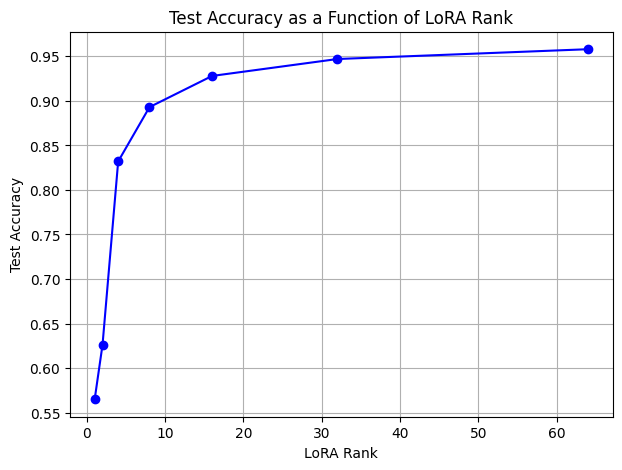

In [ ]:
plt.figure(figsize=(7, 5))
ranks = [1, 2, 4, 8, 16, 32, 64]
accuracies = list(test_accuracies.values())
plt.plot(ranks, accuracies, marker='o', linestyle='-', color='b')
plt.title('Test Accuracy as a Function of LoRA Rank')
plt.xlabel('LoRA Rank')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

<font color='blue'> Let's now show the number of parameters of the model as a function of LoRA rank:

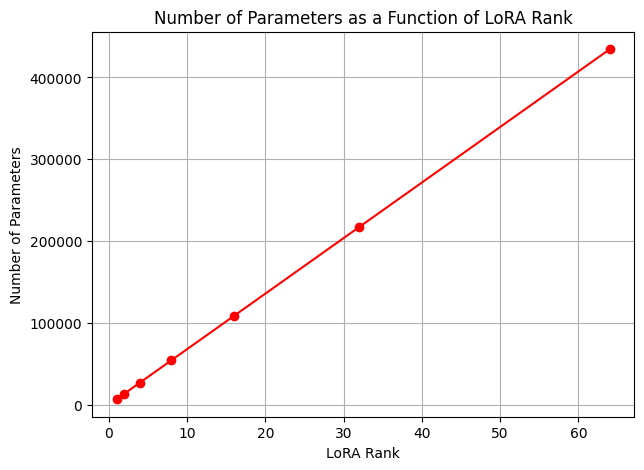

In [ ]:
plt.figure(figsize=(7, 5))
num_params_values = list(num_parameters.values())
plt.plot(ranks, num_params_values, marker='o', linestyle='-', color='r')
plt.title('Number of Parameters as a Function of LoRA Rank')
plt.xlabel('LoRA Rank')
plt.ylabel('Number of Parameters')
plt.grid(True)
plt.show()

<font color='blue'> **Comments:**

<font color='blue'> The main observation is that the test set accuracy increases when we increase the lora_rank. For lora_rank=1, we obtain a test accuracy of 0.565, while for lora_rank=64 the accuracy is equal to 0.958. However, as we have seen in the red plot, the number of parameters of the model also increases linearly with the rank. This presents a tradeoff between accuracy and number of parameters. By looking at the plots, we could say than an optimal value for lora_rank would be around 35. Indeed, for lora_rank=32, we obtain a test accuracy of 0.947, which is near to the one obtained with traditional fine-tuning (with the same number of epochs and with almost 13 times less parameters trained!).

 <font color='blue'> The main advantage of LoRA is that it updates only a small subset of the model's parameters, which allows for quick adaptation to new tasks or datasets without the need for extensive retraining. In this TP we have tested it on MNIST, but it can be extended to more complex applications. Indeed, its efficiency makes it particularly useful for enhancing natural language processing for domain-specific tasks, improving image recognition in computer vision, personalizing recommendation systems, and adapting autonomous systems for specific environments. Overall, LoRA leverages the strength of large pre-trained models, by making their fine-tuning much more efficient.

In [ ]:
# Dictionnaries obtained after training

print(test_accuracies)
print(num_parameters)

{'test_accuracy_1': 0.565, 'test_accuracy_2': 0.626, 'test_accuracy_4': 0.832, 'test_accuracy_8': 0.893, 'test_accuracy_16': 0.928, 'test_accuracy_32': 0.947, 'test_accuracy_64': 0.958}
{'num_param_rank_1': 6789, 'num_param_rank_2': 13578, 'num_param_rank_4': 27156, 'num_param_rank_8': 54312, 'num_param_rank_16': 108624, 'num_param_rank_32': 217248, 'num_param_rank_64': 434496}
